In [2]:
!pip install lightgbm
!pip install econml

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import scipy as sp
import statsmodels.formula.api as smf
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBClassifier
import warnings
from econml.dml import CausalForestDML

warnings.filterwarnings("ignore")
np.random.seed(123)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<h1><center> Causal Inference - Final Project </center></h1>
<h2><center> Should We Ever Use Linear Difference-in-Differences? </center></h2>
<h3><center> El Gataa Charif </center></h3>

Assume parallel trends and linear model, Difference-in-Differences allows to compute the average treatment of the treated (ATT).

But what about the ATE? And what if we have a non-linear relationship between covariates and outcome? Or we have heterogeneity in the effects of the treatment?

## Double/Debiased Machine Learning

Assume we have the following problem:

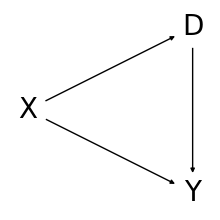

In [3]:
G = nx.DiGraph()
G.add_nodes_from(['X', 'Y', 'D'])
G.add_edge('X','Y')
G.add_edge('X','D')
G.add_edge('D','Y')
pos = nx.shell_layout(G)
plt.figure(figsize=(2, 2))
nx.draw(G, pos, with_labels=True, node_color='white', node_size=800, font_size=20, arrowsize=6)

plt.show()

where
\begin{equation*}
Y = D*β + g_0(X) + \epsilon
\end{equation*}
and
\begin{equation*}
D = m_0(X) + \xi
\end{equation*}
where we assume $X,\epsilon,\xi$ jointly independent and $\epsilon,\xi$ have 0 mean.

**Method**:

We both estimate $g_0$ and $m_0$ and get, respectively, $\hat{g}$ and $\hat{m}$. For all $i$ we compute

\begin{equation*}
R_i = Y_i - \hat{g}(X_i) \:\:\:\:\: and \:\:\:\:\: \tilde{R}_i = D_i - \hat{m}(X_i)
\end{equation*}

Set $\mathbb{E}[R(\tilde{R}-D*\beta)]=0$ and use it to estimate $\beta$ with

\begin{equation*}
\hat{\beta} = \frac{\sum_i (D_i - \hat{m}(X_i))*R_i}{\sum_i (D_i - \hat{m}(X_i))*D_i}
\end{equation*}

**Asymptotically**:

\begin{equation*}
BIAS(\hat{\beta}) \sim \frac{\mathbb{E}[(m_0(X)-\hat{m}(X))(g_0(X)-\hat{g}(X))]}{\mathbb{E}[(D-\hat{m}(X))D]}
\end{equation*}

We can bound it with the Cauchy-Schwartz inequality, which states that for all $\textbf{u}$,$\textbf{v}$ vectors in a normed vector space with inner product $<\cdot,\cdot>$:

\begin{equation*}
<u,v>\:\leq |u||v|
\end{equation*}

Therefore:

\begin{equation*}
BIAS(\hat{\beta}) \leq \mathbb{E}[(m_0(X)-\hat{m}(X))^2]^{1/2}\mathbb{E}[(g_0(X)-\hat{g}(X))^2]^{1/2}
\end{equation*}

In order to control the bias of $\hat{\beta}$, we need it to converge at a smaller rate than $o\big{(}\frac{1}{\sqrt{n}}\big{)}$ (for the CLT to hold).

This means that for the bias not to disturb the CLT, we don't need both biases of $\hat{m}$ and $\hat{g}$ to converge at a $\frac{1}{\sqrt{n}}$ rate, but only their product has to.

For example, if both biases converge at a reta of $\frac{1}{n^{\frac{1}{3}}}$, then their product converges at a rate of $\frac{1}{n^{\frac{2}{3}}}<\frac{1}{n^{\frac{1}{2}}}$ and bias of $\hat{\beta}$ goes to 0 asymptotically. Good news!

The **strategy** to use is:

*   Split the datapoints in a disjoint union of $K$ subsets of approximately equal size $\{1,...,n\}=\sum_{k=1}^K I_k$
*   For each set $k$:
    *   Regress $D$ on $X$ and get an estimate $\hat{m}^k$, save $\hat{\xi}^k=D-\hat{m}^k(X)$
    *   Regress $Y$ on $X$ and get an estimate $\hat{g}^k$, save $\hat{R}^k=Y-\hat{g}^k(X)$
    * Solve $\frac{1}{|I_k|}\sum_{i \in I_k}\hat{\xi}^k_i\cdot(\hat{R}^k_i - D_i \hat{\beta}^{k})=0$ in order to find $\hat{\beta}^k$
*   Estimate the ATE as $\hat{\beta}=\frac{1}{K}\sum_{k=1}^K\hat{\beta}^k$

Why does this method work?

**Score functions and Neyman orthogonality**:

The key input of a DML method is to find a score $\psi(\beta,\eta)$ (where $\beta$ parameter of interest and $\eta$ nuisance functions) that satisfies some properties:

* $\mathbb{E}[\psi(\beta,\eta)]=0$ if and only if $\beta=\beta_0$ the true value

* The score is Neyman orthogonal, i.e. it is robust against perturbations of the nuisance functions,

\begin{equation*}
\frac{\partial \mathbb{E}[\psi(\beta,\eta)]}{\partial \eta} = 0
\end{equation*}

**NB**: In the case above, the score that we were using was $\psi(\beta,g_0,m_0)=\epsilon(\beta,g_0) * \xi(m_0) = (D-m_0(X))*(Y-\beta*D-g_0(X))$

## Difference-in-Differences with DML

Assume we have panel data for two different periods, $T=0,1$, we have a treatment group and a control group, $D=0,1$, and treatment occurred between the two periods.

In order to perform DiD with DML, we consider a conditional version of the usual DiD assumptions:
* Conditional parallel trends assumption: $E[Y_1(0)-Y_0(0)|D=1,X]=E[Y_1(0)-Y_0(0)|D=0,X]$ a.s.
* Conditional no anticipation assumption: $E[Y_0(0)|D=1,X]=E[Y_0(1)|D=1,X]$ a.s.

Assume also a treatment group exists and its characteristichs overlap with the control group: $\exists \epsilon > 0 : P(D=1)\geq \epsilon$ and $P(D=1|X)\leq 1-\epsilon$ a.s.

We are interested in estimating the ATT
\begin{equation*}
\theta = ATT = \mathbb{E} [f_0(1,X)-f_0(0,X)|D=1]
\end{equation*}
with $Y=f_0(D,X)+\epsilon$ and $\epsilon$ has 0 mean. In our case $f_0(D,X)=D*\beta+g_0(X)$

The Neyman orthogonal score to estimate the ATT with panel data is

\begin{equation*}
\psi(W,\theta,\eta) = \frac{D - m(X)}{p(1 - m(X))}(Y - f_0(0,X)) - \frac{D*\theta}{p}
\end{equation*}

If we are inerested in te conditional DiD framework with panel data, we use the score above with $\Delta Y$ instead of $Y$.

The **algorithm** in this case is:

*   Split the datapoints in a disjoint union of $K$ subsets of approximately equal size $\{1,...,n\}=\sum_{k=1}^K I_k$
*   For each set $k$:
    *   Regress $D$ on $X$ and get an estimate $\hat{m}^k$, save $\hat{\xi}^k=D-\hat{m}^k(X)$
    *   Regress $Y$ (or $\Delta Y$) on $X$ and get an estimate $\hat{g}^k$, save $\hat{R}^k=Y-\hat{g}^k(X)$
    * Solve $\frac{1}{|I_k|}\sum_{i \in I_k} \psi(W_i,\hat{\theta}^k)=0$ in order to find $\hat{\theta}^k$
*   Estimate the ATE as $\hat{\theta}=\frac{1}{K}\sum_{k=1}^K\hat{\theta}^k$

# Synthetic data

We consider a panel data model with 2 time periods.
Assume we have $N$ observations, observed at $T=2$ time periods.
We have both individual unobservables $H_i$ and time unobservables $J_t$, and we have some individual observable characteristics $X_i$.
We denote the treatment as $D_i$ and define variable $W_{i,t}=D_i\mathbb{1}(t=1)$. We assume heterogeneity in the individual treatment effect, that depends both on individual observables and unobservables, following the functional form:
\begin{equation*}
f(H_i,X_i) = 2*\sqrt{|2H_i+X_i|}-5
\end{equation*}

so ATE is slightly positive.

Therefore, our model equation is

\begin{equation*}
Y_{i,t} = f(H_i,X_i)W_{i,t}+g(H_i,X_i,J_t)+\epsilon_{i,t}
\end{equation*}

For example, we have $N$ students that have to take a standardized test twice, between the two tests some students get some specialized training. Assume the individual unobservables are the memorization skills and the observable is the number of times each individual studied for the test. The time unobservable is the difficulty of the exam.

In order to use linear DiD, we assume $g(H_i,X_i,J_t)=H_i+X_i+J_t$

Variables are drawn from the following distributions:

* $X_i \sim Exp(1)$
* $H_i \sim N(3,1)$
* $J_t \sim U(1,3)$
* $\epsilon_{i,t} \sim N(0,0.5)$

Treatment assignment depends on individual confounders, both observed and unobserved, i.e.
\begin{equation*}
D_i = \mathbb{1}(f(H_i,X_i)+\xi_i>0) \:\:\:\:\:\:\:\:\: \xi_i \sim N(0,1)
\end{equation*}

Therefore, not all the students that would benefit the training will be chosen to attend it.



In [4]:
# data generating process

def f(x,y):
  return 2*np.sqrt(abs(2*x+y))-5

def generate_data(n, t):
  df = pd.DataFrame({
  "i": np.repeat(np.arange(0, n), t),
  "t": np.tile(np.arange(0, t), n),
  "X": np.repeat(np.random.exponential(1, n), t),
  "H": np.repeat(np.random.normal(3, 1, n), t),
  "J": np.tile(np.random.uniform(1, 3, t), n),
  "error": np.random.normal(0, 0.5, n * t),
  })
  return df

def assign_treatment(df):
  df["xi"] = np.repeat(np.random.normal(0, 1, int(df.shape[0]/2)), 2)
  df["D"] = np.where(f(df["H"], df["X"]) + df["xi"] > 0, 1, 0)
  df["W"] = df["D"] * df["t"]
  return df

def assign_outcome(df):
  df["Y"] = f(df["H"], df["X"]) * df["W"] + df["H"] + df["X"] +df["J"] + df["error"]
  return df

def print_observables(df):
  return df.drop(columns=["H", "error", "xi"]).head()

How the data set looks like:

In [5]:
# generate data set

df = generate_data(10000, 2)
df = assign_treatment(df)
df = assign_outcome(df)

# print observables

print_observables(df)

,i,t,X,J,D,W,Y
0,0,0,1.192272,2.251299,1,0,7.243204
1,0,1,1.192272,1.042101,1,1,7.367739
2,1,0,0.337067,2.251299,0,0,6.349928
3,1,1,0.337067,1.042101,0,0,5.744355
4,2,0,0.257284,2.251299,1,0,4.637126


### True effects:

In [6]:
def print_true_effects(df):

    # Calculate the individual treatment effects
    df['tau'] = f(df['H'], df['X'])

    # Calculate and print the ATE
    ATE = df['tau'].mean()
    ATE_std = df['tau'].std() / np.sqrt(len(df))
    print(f"ATE: {ATE:.2f} ± {ATE_std:.2f}")

    # Calculate and print the ATT
    ATT = df[df['D'] == 1]['tau'].mean()
    ATT_std = df[df['D'] == 1]['tau'].std() / np.sqrt(df['D'].sum())
    print(f"ATT: {ATT:.2f} ± {ATT_std:.2f}")

    # Calculate and print the ATC
    ATC = df[df['D'] == 0]['tau'].mean()
    ATC_std = df[df['D'] == 0]['tau'].std() / np.sqrt(len(df) - df['D'].sum())
    print(f"ATC: {ATC:.2f} ± {ATC_std:.2f}")

In [7]:
print_true_effects(df)

ATE: 0.23 ± 0.01
ATT: 0.62 ± 0.01
ATC: -0.30 ± 0.01


We can look at the distribution of individual treatment effects, by treatment status

[Text(0.5, 0, ''), Text(0.5, 1.0, 'Individual Treatment Effects')]

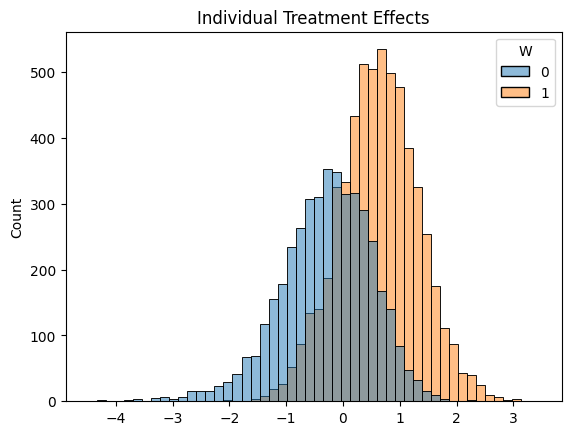

In [8]:
# plot of distribution of individual treatment effects
g = sns.histplot(data=df[df.t==1], x="tau", hue="W", bins=50)
g.set(xlabel="", title="Individual Treatment Effects")

Types are also reflected in true propensity scores.

[Text(0.5, 0, ''), Text(0.5, 1.0, "'True' Propensity Scores")]

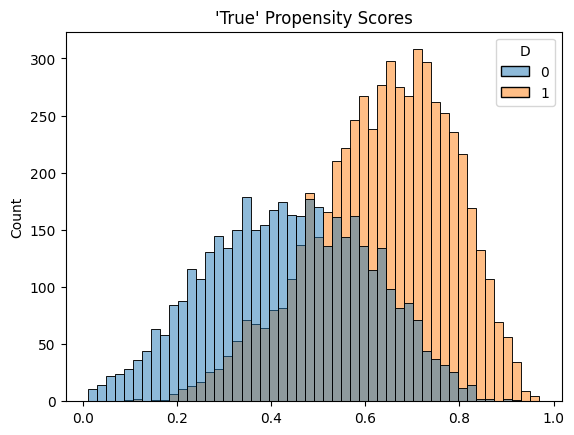

In [9]:
# propensity scores
df['e'] = sp.special.expit(df["tau"])

# plot
g = sns.histplot(data=df[df.t == 1], x="e", hue="D", bins=50)
g.set(xlabel="", title="'True' Propensity Scores")

### Analysis with observables

### Linear DID:

Before computing difference in differences, let's have a look at difference in means in treatment and control groups.

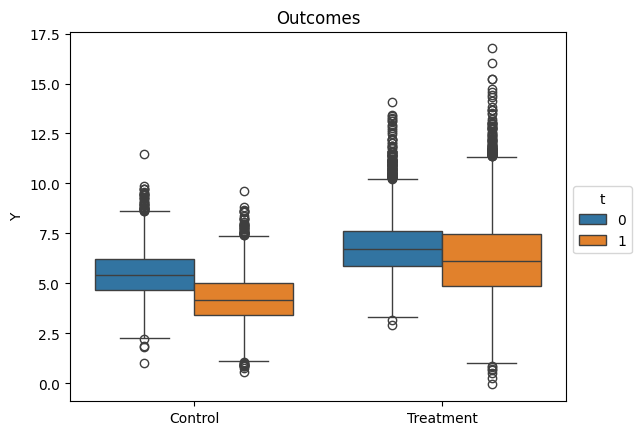

In [10]:
g = sns.boxplot(data=df, x="D", y="Y", hue="t")
g.set(xlabel="", title="Outcomes", xticklabels=["Control", "Treatment"])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.6))

This is what we need to know in order to estimate the DiD.

Now, let's compute the DiD:

In [11]:
smf.ols("Y ~ 1 + t * D + X", data=df).fit(cov_type="cluster", cov_kwds={"groups": df.i}).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,4.7209,0.018,256.954,0.000,4.685,4.757
t,-1.2135,0.011,-112.295,0.000,-1.235,-1.192
D,0.9661,0.021,46.056,0.000,0.925,1.007
t:D,0.6313,0.017,37.356,0.000,0.598,0.664
X,0.9933,0.013,76.168,0.000,0.968,1.019


### DML DID:

In [12]:
def final_stage(D, y, Dhat, yhat, phat):
    # doubly robust quantity for every sample
    phihat = ((D - Dhat) / (phat * (1 - Dhat))) * (y - yhat)
    point = np.mean(phihat) / np.mean(D / phat)
    # influence function
    phihat = (phihat - point * (D / phat)) / np.mean(D / phat)
    var = np.mean(np.square(phihat))
    stderr = np.sqrt(var / D.shape[0])
    return point, stderr


def dr_att(X, D, y, modely, modeld, *, trimming=0.01, nfolds=5):

#   DML for the ATT estimation

#   Input
#   X: the controls, pandas DataFrame
#   D: treatment indicator, numpy array
#   y: the outcome (the delta before and after intervention in DiD), numpy array
#   modely: the ML model for predicting y (the delta Y_1 - Y_0 in DiD)
#   modeld: the ML model for predicting the treatment D
#   trimming: threshold below which to trim propensities, float (default=0.01)
#   nfolds: the number of folds in cross-fitting, int (default=5)

#   Output
#   point: the point estimate of the treatment on the treated
#   stderr: the standard error of the treatment effect
#   yhat: cross-fitted predictions of the outcome y under control, E[y|D=0, X]
#   Dhat: cross-fitted predictions of the treatment D, E[D|X]
#   rmsey: the RMSE of the model y ~ X | D==0
#   rmseD: the RMSE of the model D ~ X
#   phat: the estimated treatment probability in each fold

    cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1234)
    # fit a model E[y | D=0, X]
    yhat = np.zeros(y.shape)
    for train, test in cv.split(X, D):
        modely.fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
        yhat[test] = modely.predict(X.iloc[test])
    # fit a model E[D]
    phat = cross_val_predict(DummyRegressor(), X, D, cv=cv)
    # propensity scores E[D | X]
    Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba')[:, 1]
    # trimm propensity score
    Dhat = np.clip(Dhat, trimming, 1 - trimming)
    # estimation of parameter
    point, stderr = final_stage(D, y, Dhat, yhat, phat)
    # nuisance function rmse's
    rmsey = np.sqrt(np.mean((y - yhat)[D == 0]**2))
    rmseD = np.sqrt(np.mean((D - Dhat)**2))
    return point, stderr, yhat, Dhat, rmsey, rmseD, phat

In order to compute the DML DID we need to choose the learners to estimare $m(X)$ and $g(X)$.

The usual choice of $m(X)$ is a logistic regression, since outcome is binary (treatment assignment) and covariates are real continuous. Usual choice of $g(X)$ is Lasso. The choice is ideal for our case as outcome model is linear and propensity score model is logit.

In [13]:
# prepare data
# we need to have a dataset with these observations: for each i (∆Y,D,X)

df_y = df['Y']
df_dml = df_y.diff(1).iloc[1::2]

# new indexes from 1 to 5000
df_dml.index = np.arange(0, len(df_dml))

# save even rows of values D and X of initial dataset
df_dx = df[['D','X']].iloc[1::2]
df_dx.index = np.arange(0, len(df_dx))
df_dx

# merge df_dml and df_dx
df_dml = pd.concat([df_dml, df_dx], axis=1)

In [14]:
point, stderr, yhat, Dhat, rmsey, rmseD, phat = dr_att(df_dml[['X']], df_dml['D'], df_dml['Y'], LassoCV(), LogisticRegressionCV())

In [15]:
print(f"ATT: {point:.2f} ± {stderr:.2f}")

ATT: 0.62 ± 0.02


The DML works pretty well, let's look at the estimates of the propensity scores

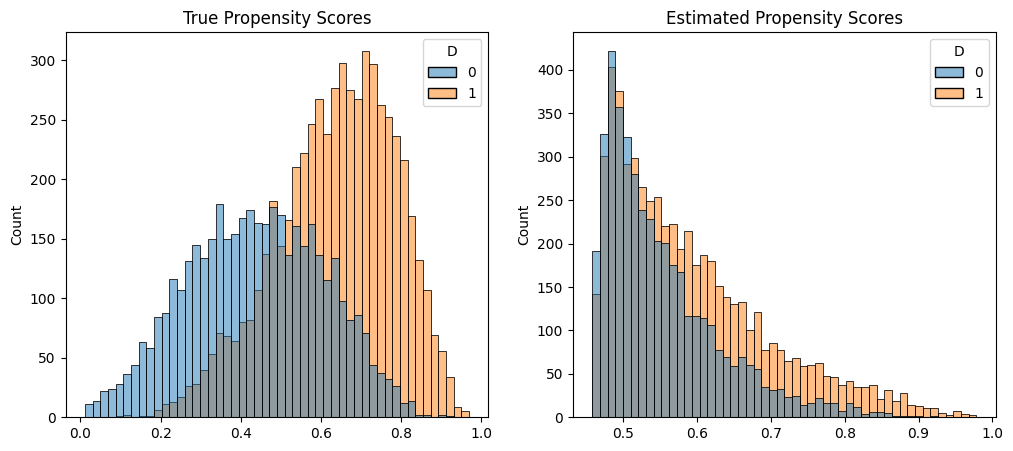

<Figure size 600x250 with 0 Axes>

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df[df.t == 1], x="e", hue="D", bins=50, ax=axes[0])
axes[0].set(xlabel="", title="True Propensity Scores")

sns.histplot(x=Dhat, hue=df_dml["D"], bins=50, ax=axes[1])
axes[1].set(xlabel="", title="Estimated Propensity Scores")

plt.figure(figsize=(6,2.5))
plt.show()

Propensity scores (i.e. $m(X)$) are misspecified, but model correctly estimates the ATT, how is this possible?

### What if the parallel trends assumption is not satisfied?


Assume that temporal shocks are not additive but multiplicative:
\begin{equation*}
Y_{i,t} = J_t*(f(H_i,X_i)W_{i,t}+H_i+X_i+\epsilon_{i,t})
\end{equation*}

In [17]:
def assign_outcome_2(df):
  df["Y"] = df["J"] * (f(df["H"], df["X"]) * df["W"] + df["H"] + df["X"] + df["error"])
  return df

In [18]:
# generate data set

df_2 = generate_data(5000, 2)
df_2 = assign_treatment(df_2)
df_2 = assign_outcome_2(df_2)

# print observables

print_observables(df_2)

,i,t,X,J,D,W,Y
0,0,0,0.064217,1.792603,0,0,4.215528
1,0,1,0.064217,2.225087,0,0,5.431602
2,1,0,0.601694,1.792603,1,0,9.377039
3,1,1,0.601694,2.225087,1,1,10.954187
4,2,0,0.044100,1.792603,0,0,3.853829


Let's compute the true effect first:

In [19]:
# true effect
print_true_effects(df_2)

ATE: 0.23 ± 0.01
ATT: 0.63 ± 0.01
ATC: -0.30 ± 0.01


### Linear DiD:

In [20]:
smf.ols("Y ~ 1 + t * D + X", data=df_2).fit(cov_type="cluster", cov_kwds={"groups": df_2.i}).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,4.2242,0.048,87.632,0.000,4.130,4.319
t,1.3768,0.033,41.578,0.000,1.312,1.442
D,1.5560,0.056,27.767,0.000,1.446,1.666
t:D,2.0766,0.058,35.892,0.000,1.963,2.190
X,2.0613,0.034,59.894,0.000,1.994,2.129


### DML DiD Effect:

In [21]:
# prepare data
# we need to have a dataset with these observations: for each i (∆Y,D,X)

df_2_y = df_2['Y']
df_2_dml = df_2_y.diff(1).iloc[1::2]

# new indexes from 1 to 5000
df_2_dml.index = np.arange(0, len(df_2_dml))

# save even rows of values D and X of initial dataset
df_2_dx = df_2[['D','X']].iloc[1::2]
df_2_dx.index = np.arange(0, len(df_2_dx))
df_2_dx

# merge df_dml and df_dx
df_2_dml = pd.concat([df_2_dml, df_2_dx], axis=1)

In [22]:
point_2, stderr_2, yhat_2, Dhat_2, rmsey_2, rmseD_2, phat_2 = dr_att(df_2_dml[['X']], df_2_dml['D'], df_2_dml['Y'], LassoCV(), LGBMClassifier(n_estimators=50, verbose=-1), trimming=0)

In [23]:
print(f"ATT: {point_2:.2f} ± {stderr_2:.2f}")

ATT: 1.96 ± 0.07


We can look at the propensity scores again:

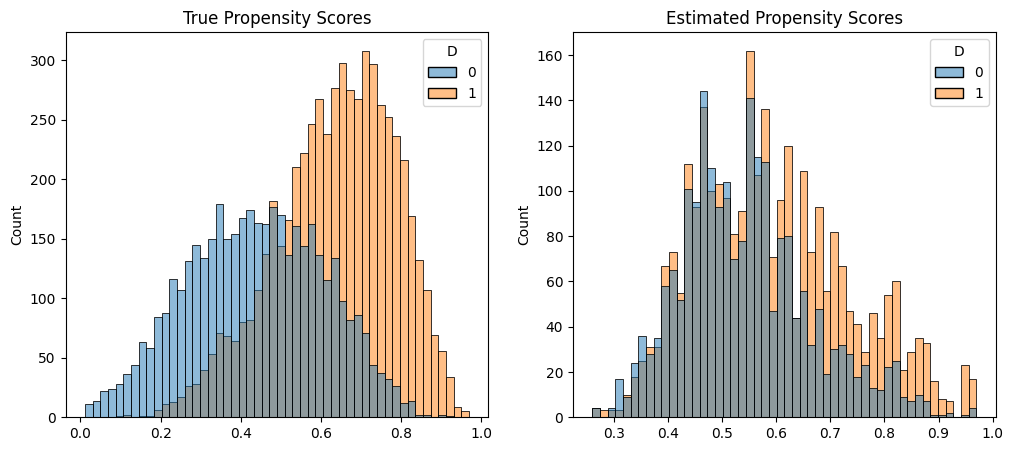

<Figure size 600x250 with 0 Axes>

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df[df.t == 1], x="e", hue="D", bins=50, ax=axes[0])
axes[0].set(xlabel="", title="True Propensity Scores")

sns.histplot(x=Dhat_2, hue=df_2_dml["D"], bins=50, ax=axes[1])
axes[1].set(xlabel="", title="Estimated Propensity Scores")

plt.figure(figsize=(6,2.5))
plt.show()

Estimated propensity scores are much more “binned” than their logistic regression equivalent, as expected from a forest method.

What if we use a Logistic Regression for PS estimation here again?

In [25]:
point_3, stderr_3, yhat_3, Dhat_3, rmsey_3, rmseD_3, phat_3 = dr_att(df_2_dml[['X']], df_2_dml['D'], df_2_dml['Y'], LassoCV(), LogisticRegressionCV(), trimming=0)

In [26]:
print(f"ATT: {point_3:.2f} ± {stderr_3:.2f}")

ATT: 1.92 ± 0.06


The value of the ATT with (LogisticRegressionCV,LassoCV) is really similar to the one obtained using linear DiD.

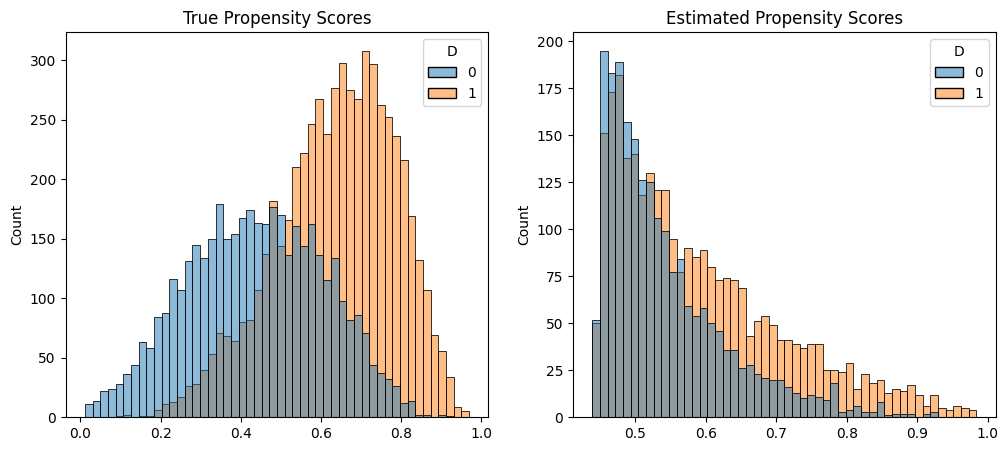

<Figure size 600x250 with 0 Axes>

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df[df.t == 1], x="e", hue="D", bins=50, ax=axes[0])
axes[0].set(xlabel="", title="True Propensity Scores")

sns.histplot(x=Dhat_3, hue=df_2_dml["D"], bins=50, ax=axes[1])
axes[1].set(xlabel="", title="Estimated Propensity Scores")

plt.figure(figsize=(6,2.5))
plt.show()

We can also try using neural networks for a non-linear regression of Y on X, although this attempt, detailed in the Appendix, wasn't successful.

## 🙅**Warning: We are cheating**🙅



In practice, selecting the appropriate method can be challenging. While RMSE gives some guidance, it doesn't give information about similarity between the estimated values and the true underlying effects. Moreover, in many cases, like ours, RMSE values are really similar to each other and it's hard to say that one method is better than the other because its RMSE is 10e-x orders of magnitude lower, with x arbitrarily big.

In [28]:
# if we consider at least 4 numbers after comma
print(f"RMSE of LGBMClassifier: {rmsey_2:.5f}")
print(f"RMSE of LogisticRegressionCV: {rmsey_3:.5f}")

RMSE of LGBMClassifier: 1.51417
RMSE of LogisticRegressionCV: 1.51417


We will discuss model selection in the empirical section.

# Empirical data

#### IRCA
Immigration Reform and Control Act (1986).

IRCA provided access to legal status for undocumented immigrants who had been living in the U.S. continuously since before January 1, 1982.

Approximately 2.7 million people were granted legal status under the act.

In [57]:
# read CSV
df_IRCA = pd.read_csv('CENSUSdat2000.csv', nrows=995957)

# shape of df_IRCA (double check step)
print(df_IRCA.shape)

(995957, 97)


In [58]:
# Clean data

# Keep individuals that are more than 16 and less than 54
df_IRCA_1 = df_IRCA[(df_IRCA['age'] >= 16) & (df_IRCA['age'] <= 54)]

# Keep if individual comes from Mexico, Guatemala, El Salvador, Colombia, i.e. mexico==1|bpld==21030|bpld==21040|bpld==30025
df_IRCA_1 = df_IRCA_1[(df_IRCA_1['mexico']==1)|(df_IRCA_1['bpld']==21030)|(df_IRCA_1['bpld']==21040)|(df_IRCA_1['bpld']==30025)]

# Keep indivisuals who don't work in agriculture, i.e. drop if occ1990 >= 473 & occ1990 <= 484
df_IRCA_1 = df_IRCA_1[(df_IRCA_1['occ1990']<473)|(df_IRCA_1['occ1990']>484)]

# Define new variable age of immigration ageimmig as age - yrsus
df_IRCA_2 = df_IRCA_1.copy()
df_IRCA_2.loc[:, 'ageimmig'] = df_IRCA_2['age'] - df_IRCA_2['yrsus']

# Keep if age of immigration is above or equal to 20
df_IRCA_2 = df_IRCA_2[df_IRCA_2['ageimmig']>=20]

# Keep if year of immigration is between 1970 and 1990
df_IRCA_2 = df_IRCA_2[(df_IRCA_2['yrimmig']>=1973)&(df_IRCA_2['yrimmig']<=1990)]

# define post82 dummy
df_IRCA_2['pre82'] = (df_IRCA_2['yrimmig'] < 1982).astype(int)

# define citizenship dummy
df_IRCA_2['citi'] = (df_IRCA_2['citizen'] <= 2).astype(int)

# Adress men and women separately
df_IRCA_men = df_IRCA_2[df_IRCA_2['sex']==1]
df_IRCA_women = df_IRCA_2[df_IRCA_2['sex']==2]

In [59]:
# compute new variable with mean fraction of citizens per year of immigration in df_IRCA_men

citizen_fraction_by_year = df_IRCA_men.groupby('yrimmig')['citi'].mean()
df_IRCA_men = df_IRCA_men.merge(citizen_fraction_by_year, on='yrimmig', suffixes=('', '_mean'))
df_IRCA_men = df_IRCA_men.rename(columns={'citi_mean': 'mean_citizen_fraction'})

# compute new variable with mean fraction of citizens per year of immigration in df_IRCA_women

citizen_fraction_by_year_women = df_IRCA_women.groupby('yrimmig')['citi'].mean()
df_IRCA_women = df_IRCA_women.merge(citizen_fraction_by_year_women, on='yrimmig', suffixes=('', '_mean'))
df_IRCA_women = df_IRCA_women.rename(columns={'citi_mean': 'mean_citizen_fraction'})

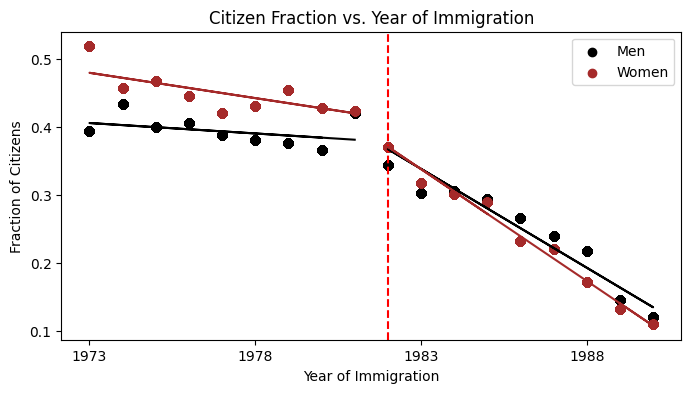

In [60]:
# Plot

plt.figure(figsize=(8, 4))

# Scatter plot for men
plt.scatter(df_IRCA_men['yrimmig'], df_IRCA_men['mean_citizen_fraction'], color='black', label='Men')

# Scatter plot for women
plt.scatter(df_IRCA_women['yrimmig'], df_IRCA_women['mean_citizen_fraction'], color='brown', label='Women')

plt.xlabel('Year of Immigration')
plt.ylabel('Fraction of Citizens')
plt.title('Citizen Fraction vs. Year of Immigration')

xticks = np.arange(min(df_IRCA_men['yrimmig']), max(df_IRCA_men['yrimmig'])+1, 5)
plt.xticks(xticks)

plt.axvline(x=1982, color='red', linestyle='--')

# OLS lines for men
before_1982_men = df_IRCA_men[df_IRCA_men['yrimmig'] < 1982]
ols_before_men = smf.ols('mean_citizen_fraction ~ yrimmig', data=before_1982_men).fit()
plt.plot(before_1982_men['yrimmig'], ols_before_men.predict(before_1982_men), color='black')

after_1982_men = df_IRCA_men[df_IRCA_men['yrimmig'] >= 1982]
ols_after_men = smf.ols('mean_citizen_fraction ~ yrimmig', data=after_1982_men).fit()
plt.plot(after_1982_men['yrimmig'], ols_after_men.predict(after_1982_men), color='black')

# OLS lines for women
before_1982_women = df_IRCA_women[df_IRCA_women['yrimmig'] < 1982]
ols_before_women = smf.ols('mean_citizen_fraction ~ yrimmig', data=before_1982_women).fit()
plt.plot(before_1982_women['yrimmig'], ols_before_women.predict(before_1982_women), color='brown')

after_1982_women = df_IRCA_women[df_IRCA_women['yrimmig'] >= 1982]
ols_after_women = smf.ols('mean_citizen_fraction ~ yrimmig', data=after_1982_women).fit()
plt.plot(after_1982_women['yrimmig'], ols_after_women.predict(after_1982_women), color='brown')

plt.legend()
plt.show()

### Linear DiD on Wages

First let's plot the wages as we did for the fractions of citizens

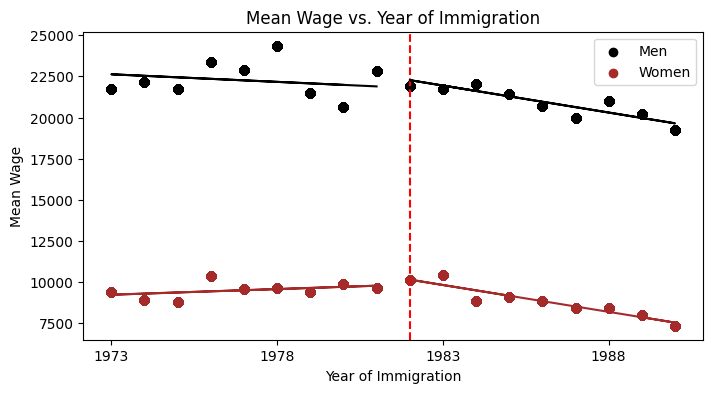

In [61]:
# compute mean wages per year of immigration in df_IRCA_men
mean_wage_by_year = df_IRCA_men.groupby('yrimmig')['wage'].mean()
df_IRCA_men = df_IRCA_men.merge(mean_wage_by_year, on='yrimmig', suffixes=('', '_mean'))
df_IRCA_men = df_IRCA_men.rename(columns={'wage_mean': 'mean_wage'})

# compute mean wages per year of immigration in df_IRCA_women
mean_wage_by_year_women = df_IRCA_women.groupby('yrimmig')['wage'].mean()
df_IRCA_women = df_IRCA_women.merge(mean_wage_by_year_women, on='yrimmig', suffixes=('', '_mean'))
df_IRCA_women = df_IRCA_women.rename(columns={'wage_mean': 'mean_wage'})

# Plot

plt.figure(figsize=(8, 4))

# Scatter plot men
plt.scatter(df_IRCA_men['yrimmig'], df_IRCA_men['mean_wage'], color='black', label='Men')

# Scatter plot women
plt.scatter(df_IRCA_women['yrimmig'], df_IRCA_women['mean_wage'], color='brown', label='Women')

plt.xlabel('Year of Immigration')
plt.ylabel('Mean Wage')
plt.title('Mean Wage vs. Year of Immigration')

xticks = np.arange(min(df_IRCA_men['yrimmig']), max(df_IRCA_men['yrimmig'])+1, 5)
plt.xticks(xticks)

plt.axvline(x=1982, color='red', linestyle='--')

# Slopes for men
before_1982_men = df_IRCA_men[df_IRCA_men['yrimmig'] < 1982]
ols_before_men = smf.ols('mean_wage ~ yrimmig', data=before_1982_men).fit()
plt.plot(before_1982_men['yrimmig'], ols_before_men.predict(before_1982_men), color='black')

after_1982_men = df_IRCA_men[df_IRCA_men['yrimmig'] >= 1982]
ols_after_men = smf.ols('mean_wage ~ yrimmig', data=after_1982_men).fit()
plt.plot(after_1982_men['yrimmig'], ols_after_men.predict(after_1982_men), color='black')

# Slopes for women
before_1982_women = df_IRCA_women[df_IRCA_women['yrimmig'] < 1982]
ols_before_women = smf.ols('mean_wage ~ yrimmig', data=before_1982_women).fit()
plt.plot(before_1982_women['yrimmig'], ols_before_women.predict(before_1982_women), color='brown')

after_1982_women = df_IRCA_women[df_IRCA_women['yrimmig'] >= 1982]
ols_after_women = smf.ols('mean_wage ~ yrimmig', data=after_1982_women).fit()
plt.plot(after_1982_women['yrimmig'], ols_after_women.predict(after_1982_women), color='brown')

plt.legend()
plt.show()

Now we use a linear DiD and assume the relation between outcome and (treatment,covariates) is linear.

In [62]:
# men
smf.ols("wage ~ 1 + yrimmig * pre82 + age + C(educrec)", data=df_IRCA_men).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.302e+05,1.29e+05,6.443,0.000,5.78e+05,1.08e+06
C(educrec)[T.2],-890.7961,566.068,-1.574,0.116,-2000.300,218.708
C(educrec)[T.3],1336.5633,415.302,3.218,0.001,522.564,2150.563
C(educrec)[T.4],2907.7446,559.594,5.196,0.000,1810.930,4004.559
C(educrec)[T.5],2309.2392,808.014,2.858,0.004,725.516,3892.962
C(educrec)[T.6],1815.2252,850.460,2.134,0.033,148.307,3482.143
C(educrec)[T.7],4542.5616,439.123,10.345,0.000,3681.871,5403.252
C(educrec)[T.8],8594.6910,522.693,16.443,0.000,7570.201,9619.181
C(educrec)[T.9],2.249e+04,645.517,34.844,0.000,2.12e+04,2.38e+04
yrimmig,-407.9387,64.697,-6.305,0.000,-534.745,-281.132


In [63]:
# women
smf.ols("wage ~  1 + yrimmig * pre82 + age + C(educrec)", data=df_IRCA_women).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.066e+05,9.05e+04,6.706,0.000,4.29e+05,7.84e+05
C(educrec)[T.2],-87.1667,389.123,-0.224,0.823,-849.858,675.524
C(educrec)[T.3],467.8739,290.167,1.612,0.107,-100.860,1036.608
C(educrec)[T.4],1147.0048,396.979,2.889,0.004,368.916,1925.093
C(educrec)[T.5],896.5110,598.439,1.498,0.134,-276.445,2069.467
C(educrec)[T.6],1345.9905,624.317,2.156,0.031,122.312,2569.669
C(educrec)[T.7],2794.3391,309.227,9.037,0.000,2188.246,3400.433
C(educrec)[T.8],6419.7446,383.297,16.749,0.000,5668.473,7171.016
C(educrec)[T.9],1.272e+04,471.250,26.987,0.000,1.18e+04,1.36e+04
yrimmig,-302.3493,45.408,-6.658,0.000,-391.351,-213.348


With DML:

In [64]:
# set educrec as categorical variable
df_IRCA_men['educrec'] = df_IRCA_men['educrec'].astype('category')
df_IRCA_women['educrec'] = df_IRCA_women['educrec'].astype('category')

First we need to choose the model, we're going to do it by comparing the RMSEs:

In [65]:
# define function that computes polynomial features of variables and interactions
def poly():
        return PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

In [66]:
# list of all used learners

learners = {
        # no X
        "No Controls": (DummyRegressor(strategy="mean"), DummyClassifier(strategy="prior")),
        # linear models of X
        "Linear models": (LinearRegression(), LogisticRegression(random_state=123)),
        # third degree interactions, with Ridge
        "Ridge": (make_pipeline(poly(), RidgeCV()),
                       make_pipeline(poly(), LogisticRegressionCV(random_state=123))),
        # third degree interactions, with Lasso
        "Lasso": (make_pipeline(poly(), LassoCV(random_state=123)),
                       make_pipeline(poly(), LogisticRegressionCV(random_state=123))),
        # Random Forest regressors and classifiers
        "Random Forest": (RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4,
                                                random_state=123),
                          RandomForestClassifier(n_estimators=100, min_samples_leaf=20, max_features=4,
                                                random_state=123)),
        # LGBM regressor and classifier
        "Light Gradient Boosting": (LGBMRegressor(n_estimators=500, verbose=-1, random_state=123),
                                    LGBMClassifier(n_estimators=100, verbose=-1, random_state=123))
    }

Men:

In [67]:
# set up data
X = df_IRCA_men[['age','educrec','yrimmig']]
D = df_IRCA_men['pre82']
Y = df_IRCA_men['wage']

# set dict to save RMSE values
att_m, se_att_m, D_hat_m, RMSE_d_m, RMSE_y_m = {}, {}, {}, {}, {}

for method, (ml_g, ml_m) in learners.items():
            print(f"Estimating {method}.")
            point, stderr, dyhat, Dhat, rmsey, rmsed, phat = dr_att(X, D, Y, ml_g, ml_m, trimming=0.01, nfolds=5)
            RMSE_y_m[method], RMSE_d_m[method] = rmsey, rmsed
            att_m[method], se_att_m[method] = point, stderr
            D_hat_m[method] = Dhat

Estimating No Controls.
Estimating Linear models.
Estimating Ridge.
Estimating Lasso.
Estimating Random Forest.
Estimating Light Gradient Boosting.


In [68]:
table1 = pd.concat(
    {
        'RMSE Y': pd.DataFrame.from_dict(RMSE_y_m, orient='index'),
        'RMSE D': pd.DataFrame.from_dict(RMSE_d_m, orient='index')
    },
    axis=1
)
table1 = table1.swaplevel(0, 1, axis=1)
table1 = table1.sort_index(axis=1)
print(table1.to_markdown())

|                         |   (0, 'RMSE D') |   (0, 'RMSE Y') |
|:------------------------|----------------:|----------------:|
| No Controls             |       0.471005  |         25189.8 |
| Linear models           |       0.0100047 |         24922.7 |
| Ridge                   |       0.0485243 |         31750.6 |
| Lasso                   |       0.0485243 |         24930.1 |
| Random Forest           |       0.01      |         24925.2 |
| Light Gradient Boosting |       0.01      |         25423.1 |


Many methods have similar RMSE scores, we use LGBM because it generalises the linear model case and it is faster than Random Forests.

In [69]:
print(f"ATT: {att_m['Light Gradient Boosting']:.2f} ± {se_att_m['Light Gradient Boosting']:.2f}")

ATT: 1676.83 ± 238.61


[Text(0.5, 0, ''), Text(0.5, 1.0, 'Estimated Propensity Scores (Men)')]

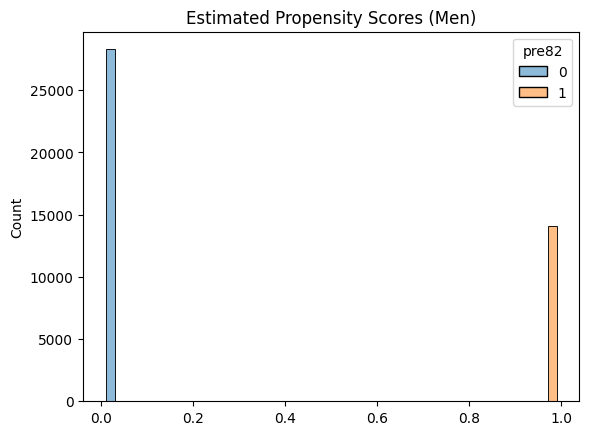

In [70]:
g = sns.histplot( x=D_hat_m['Linear models'], hue=df_IRCA_men['pre82'], bins=50)
g.set(xlabel="", title="Estimated Propensity Scores (Men)")

Women:

In [71]:
# set up data
X = df_IRCA_women[['age','educrec','yrimmig']]
D = df_IRCA_women['pre82']
Y = df_IRCA_women['wage']

# set dict to save RMSE values
att_w, se_att_w, D_hat_w, RMSE_d_w, RMSE_y_w = {}, {}, {}, {}, {}

for method, (ml_g, ml_m) in learners.items():
            print(f"Estimating {method}.")
            point, stderr, dyhat, Dhat, rmsey, rmsed, phat = dr_att(X, D, Y, ml_g, ml_m, trimming=0.01, nfolds=5)
            RMSE_y_w[method], RMSE_d_w[method] = rmsey, rmsed
            att_w[method], se_att_w[method] = point, stderr
            D_hat_w[method] = Dhat

Estimating No Controls.
Estimating Linear models.
Estimating Ridge.
Estimating Lasso.
Estimating Random Forest.
Estimating Light Gradient Boosting.


In [72]:
table1 = pd.concat(
    {
        'RMSE Y': pd.DataFrame.from_dict(RMSE_y_w, orient='index'),
        'RMSE D': pd.DataFrame.from_dict(RMSE_d_w, orient='index')
    },
    axis=1
)
table1 = table1.swaplevel(0, 1, axis=1)
table1 = table1.sort_index(axis=1)
print(table1.to_markdown())

|                         |   (0, 'RMSE D') |   (0, 'RMSE Y') |
|:------------------------|----------------:|----------------:|
| No Controls             |       0.469635  |         17273   |
| Linear models           |       0.0100002 |         17127.7 |
| Ridge                   |       0.060679  |         17982.5 |
| Lasso                   |       0.060679  |         17132.6 |
| Random Forest           |       0.01      |         17181   |
| Light Gradient Boosting |       0.01      |         17472.1 |


In [73]:
print(f"ATT: {att_w['Linear models']:.2f} ± {se_att_w['Light Gradient Boosting']:.2f}")

ATT: -1565.49 ± 165.38


[Text(0.5, 0, ''), Text(0.5, 1.0, 'Estimated Propensity Scores (Women)')]

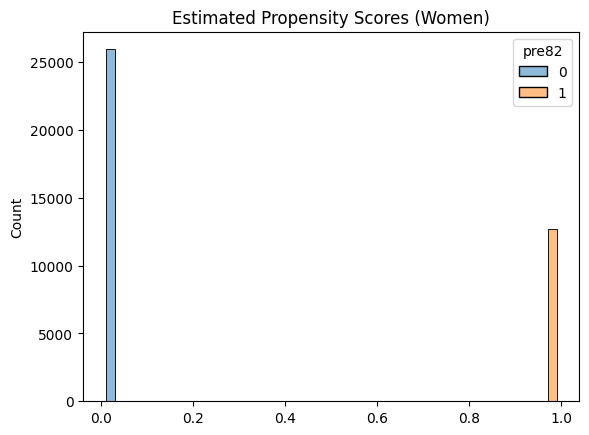

In [74]:
g = sns.histplot( x=D_hat_w['Linear models'], hue=df_IRCA_women['pre82'], bins=50)
g.set(xlabel="", title="Estimated Propensity Scores (Women)")

## References

* Chernozhukov, V. & Hansen, C. & Kallus, N. & Spindler, M. & Syrgkanis, V. (2024): Applied Causal Inference Powered by ML and AI. CausalML-book.org; arXiv:2403.02467